# Project 3 - Physics Informed Neural Networks
## Implementation using TensorFlow
...
#### Notebook initial imports and defaults

In [1]:
from networkFlowTorch import *
from PDEq import *
from support import *

from time import time

import autograd.numpy as anp
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from autograd import grad, elementwise_grad
from sklearn.metrics import r2_score

## Random seed
default_seed = 15; anp.random.seed(default_seed)

## Figure defaults
plt.rcParams["figure.figsize"] = (5,5); plt.rcParams["font.size"] = 10

2024-11-20 19:22:15.520802: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 19:22:15.537684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732126935.558316   13183 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732126935.564431   13183 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 19:22:15.585776: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
a = {0: 'a', 1: 'b', 2: 'c',3: 'd'}
print(list(a))
keys = list(a)
print(type(keys))
print(keys[2:])
print(a[keys[0]])
try:
    v = a['c']
except KeyError:
    pass 


[0, 1, 2, 3]
<class 'list'>
[2, 3]
a


### Problem setup

In [3]:
## Differential equations
test_cases = ['diff1d','burgers1d','wave1d']
test = test_cases[2]

## Coefficients
c,D,amplitude = 1.,1.,1.

if test == 'diff1d':
    PDE = Diffusion1D(sim_type='flow',amp=amplitude,D=D)
    t0,tN,x0,xN = 0,1,0,1
elif test == 'burgers1d':
    PDE = Burger1D(sim_type='flow')
    t0,tN,x0,xN = 0,1,-1,1
elif test == 'wave1d':
    PDE = Wave1D(sim_type='flow',amp=amplitude,c=c)
    t0,tN,x0,xN = 0,1,-1,1

## Defining the source function (necessary?)
f = PDE.right_hand_side

## Domain setup
Nt,Nx = 100,100

t_bound = [t0,tN]
x_bound = [x0,xN]

t = np.linspace(t_bound[0],t_bound[1],Nt)
x = np.linspace(x_bound[0],x_bound[1],Nx)
        
domain_array = np.array([t,x])

2024-11-20 19:22:18.779572: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Network configuration and initialization

In [4]:
## Layer configuration
#layer_out_sizes = [20,20,20,20,20,20,20,20,1]
layer_out_sizes = [20,20,20,1]

## Activation functions
hidden_func = 'gelu' # sigmoid, relu, elu, leaky_relu, tanh, swish, gelu, hard_sigmoid, exponential

act_funcs = []
for i in range(len(layer_out_sizes)-1):
    act_funcs.append(hidden_func)

## Output layer activation function set to identity
act_funcs.append(None); 

## Gradient descent method, regularizer and learning rate
lmbda = 1e-4
gd_method = 'adam'
eta = None #1e-2 # None
epoch = 2000

## Collocation tensor parameters
c_points = 5000; b_points = 50; i_points = 50

## Network initializtion
TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=x_bound,
                           gd_method=gd_method,
                           learning_rate=eta)

## Setup of collocation tensor
TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points,
                            plot_colloc=False)
TFNetwork.create_layers(lmbda=lmbda)

### Training the network

In [5]:
epoch = epoch

tf_net_timer = [time()]
TFNetwork.train_network(epochs=epoch)
tf_net_timer.append(time())

print('TensorFlow PINN-solver time: %.2f sec.' %(tf_net_timer[1]-tf_net_timer[0]))

Iteration: 0: Cost = 8.61663e-01
Iteration: 200: Cost = 8.45964e-03
Iteration: 400: Cost = 8.35675e-03
Iteration: 600: Cost = 7.71783e-03
Iteration: 800: Cost = 8.10399e-03
Iteration: 1000: Cost = 7.42469e-03
Iteration: 1200: Cost = 6.97530e-03
Iteration: 1400: Cost = 6.86531e-03
Iteration: 1600: Cost = 6.71997e-03
Iteration: 1800: Cost = 6.51689e-03
Final cost = 6.22065e-03
TensorFlow PINN-solver time: 81.84 sec.


### Plotting the results

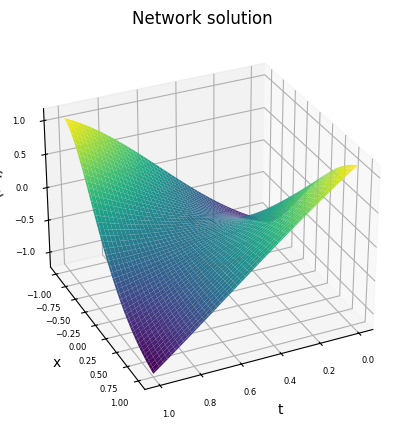

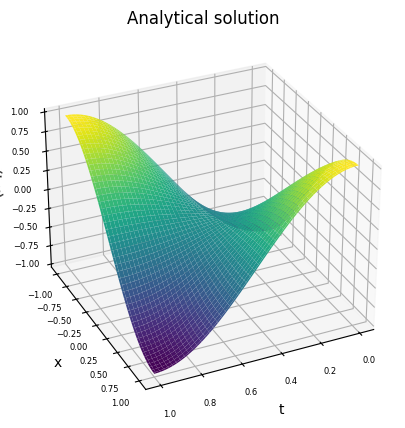

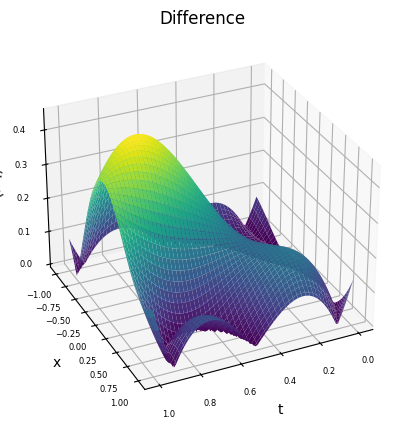

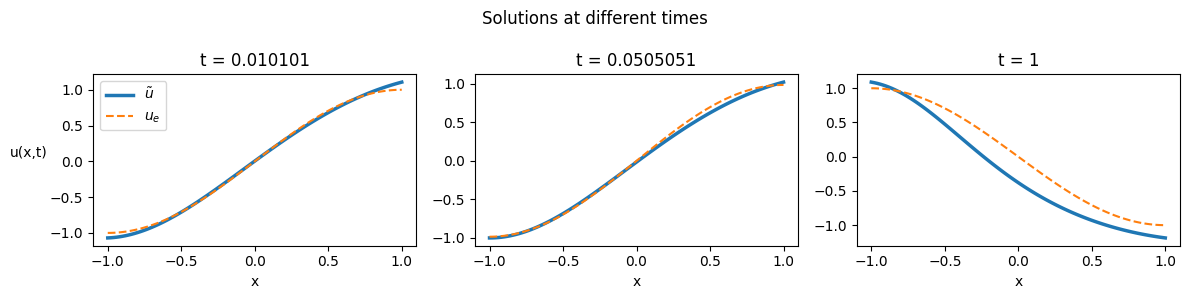

In [8]:
f_names = [str(test)+'_tf_network.png',str(test)+'_analytic.png',str(test)+'_tf_difference.png']
TFNetwork.plot_results(plots='all',
                       idx=[1,5,-1],
                       save=False,
                       f_name=f_names)

## Rerunning model at different time interval

In [7]:
t_bound = ()